In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv('MLTempDataset.csv')
df.rename(columns={"DAYTON_MW": "Temperature"}, inplace=True)
df.drop(['Unnamed: 0', 'Datetime1', 'Datetime'], axis = 1, inplace=True)

In [3]:
df.shape

(6676, 1)

<AxesSubplot:>

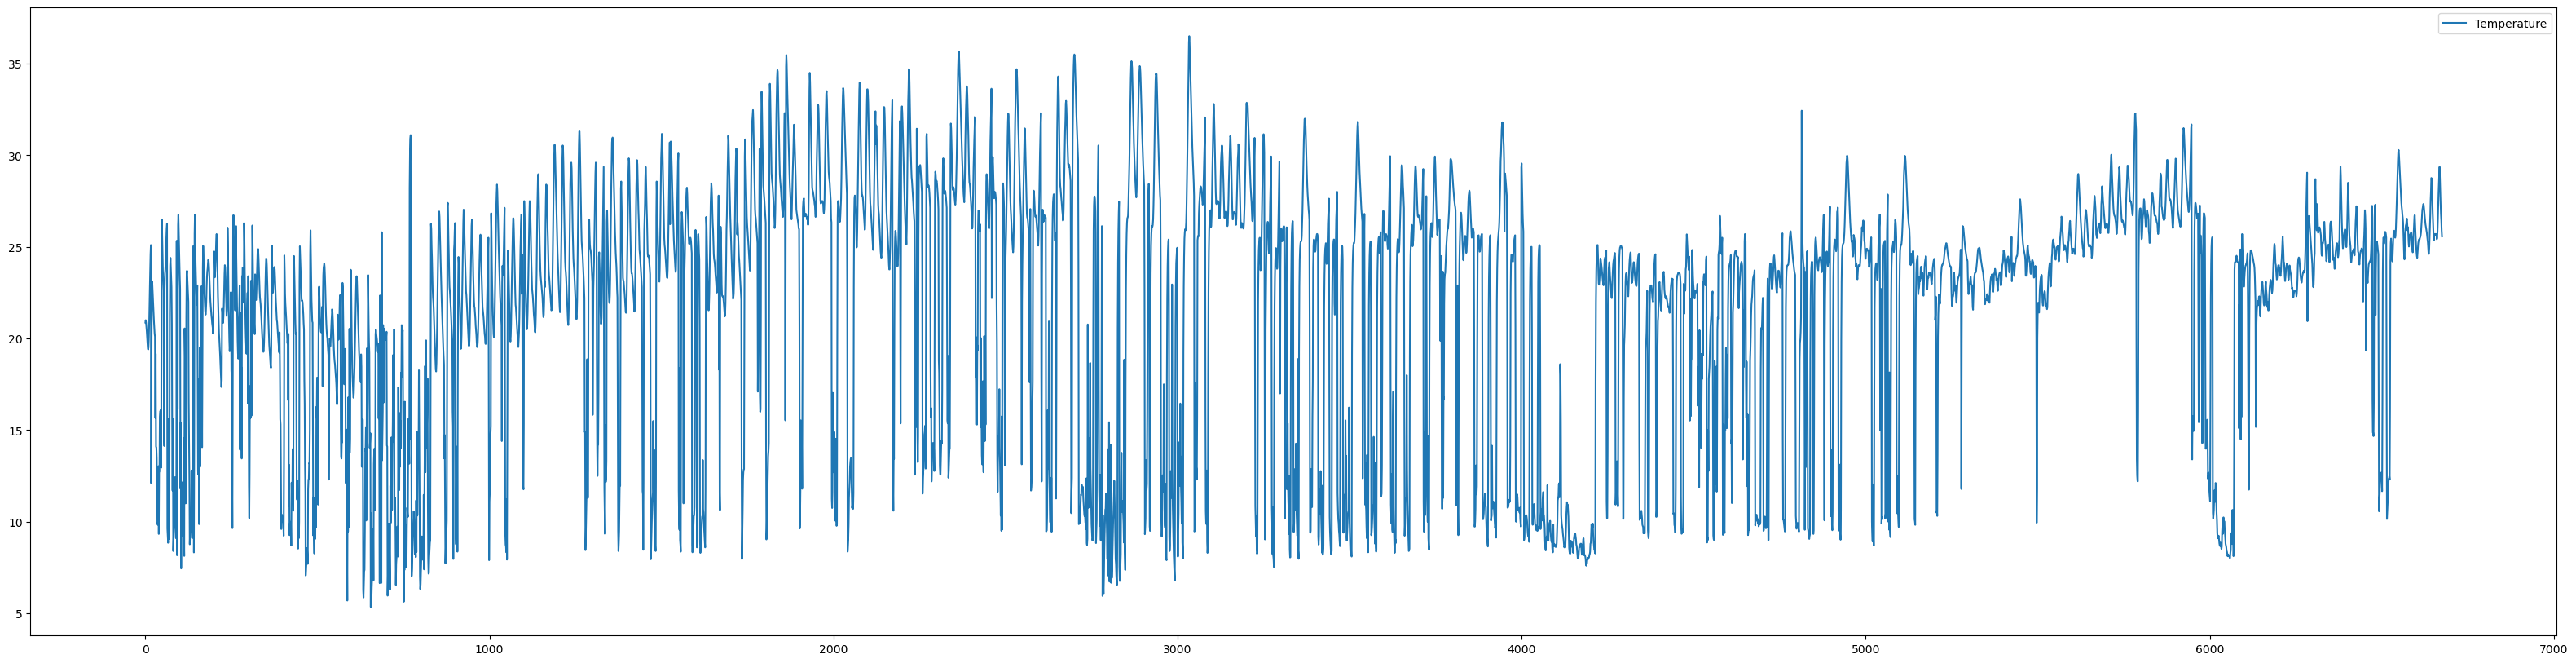

In [4]:
df.plot(figsize=(40, 10))

In [5]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Temperature"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 10

df_generated = generate_time_lags(df, input_dim)
df_generated

,Temperature,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
10,19.933,19.500,19.400,19.500,19.800,20.100,20.400,20.650,20.867,21.000,20.867
11,20.750,19.933,19.500,19.400,19.500,19.800,20.100,20.400,20.650,20.867,21.000
12,21.833,20.750,19.933,19.500,19.400,19.500,19.800,20.100,20.400,20.650,20.867
13,22.750,21.833,20.750,19.933,19.500,19.400,19.500,19.800,20.100,20.400,20.650
14,23.700,22.750,21.833,20.750,19.933,19.500,19.400,19.500,19.800,20.100,20.400
...,...,...,...,...,...,...,...,...,...,...,...
6671,27.350,28.000,28.767,29.367,28.983,28.533,27.933,27.233,26.460,25.867,25.500
6672,26.800,27.350,28.000,28.767,29.367,28.983,28.533,27.933,27.233,26.460,25.867
6673,26.450,26.800,27.350,28.000,28.767,29.367,28.983,28.533,27.933,27.233,26.460
6674,25.900,26.450,26.800,27.350,28.000,28.767,29.367,28.983,28.533,27.933,27.233


In [6]:
from sklearn.model_selection import train_test_split

X = df_generated.drop(columns=['Temperature'])
y = df_generated[['Temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
import torch.utils.data as data_utils

batch_size = 128

train = data_utils.TensorDataset(torch.tensor(X_train.values.astype(np.float32)), torch.tensor(y_train.values.astype(np.float32)))
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=False)

test = data_utils.TensorDataset(torch.tensor(X_test.values.astype(np.float32)), torch.tensor(y_test.values.astype(np.float32)))
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False)

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim=1):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [9]:
import torch.optim as optim
from sklearn.model_selection import GridSearchCV

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 4
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = GRUModel(input_dim, hidden_dim, output_dim, layer_dim=layer_dim)


In [10]:
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
train_losses = []

for epoch in range(1, n_epochs + 1):

    batch_losses = []

    for x_batch, y_batch in train_loader:

        x_batch = x_batch.view([len(x_batch), -1, input_dim])

        # Makes predictions
        yhat = model(x_batch)

        # Computes loss
        loss = loss_fn(y_batch, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()

        loss = loss.item()
        batch_losses.append(loss)

    training_loss = np.mean(batch_losses)
    train_losses.append(training_loss)

    if (epoch <= 10) | (epoch % 50 == 0):
        print(
            f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}"
        )

[1/200] Training loss: 416.6360
[2/200] Training loss: 226.9375
[3/200] Training loss: 152.0900
[4/200] Training loss: 110.3728
[5/200] Training loss: 85.0386
[6/200] Training loss: 69.9375
[7/200] Training loss: 61.2799
[8/200] Training loss: 56.5413
[9/200] Training loss: 54.0725
[10/200] Training loss: 52.8499
[50/200] Training loss: 10.2291
[100/200] Training loss: 8.8844
[150/200] Training loss: 8.5448
[200/200] Training loss: 8.4456


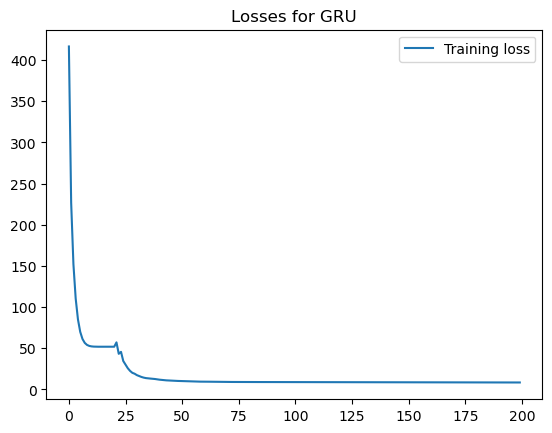

In [12]:
plt.plot(train_losses, label="Training loss")
plt.legend()
plt.title("Losses for GRU")
plt.show()
plt.close()

In [13]:
with torch.no_grad():
    predictions = []
    values = []
    for x_batch, y_batch in test_loader:
        
        x_batch = x_batch.view([len(x_batch), -1, input_dim])
        yhat = model(x_batch)
        
        predictions.append(yhat.detach().numpy())
        values.append(y_batch.detach().numpy())

In [14]:
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=X_test.head(len(vals)).index)
df_result = df_result.sort_index()

In [15]:
df_result

,value,prediction
5342,23.466999,23.797821
5343,23.200001,23.630667
5344,23.150000,23.373152
5345,22.600000,23.448776
5346,22.083000,22.766115
...,...,...
6671,27.350000,27.034147
6672,26.799999,26.390640
6673,26.450001,25.802965
6674,25.900000,25.586414


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)

In [17]:
result_metrics

{'mae': 0.7247024, 'rmse': 1.594644033956086, 'r2': 0.8789199595965824}

Text(0.5, 1.0, 'GRU (all test size)')

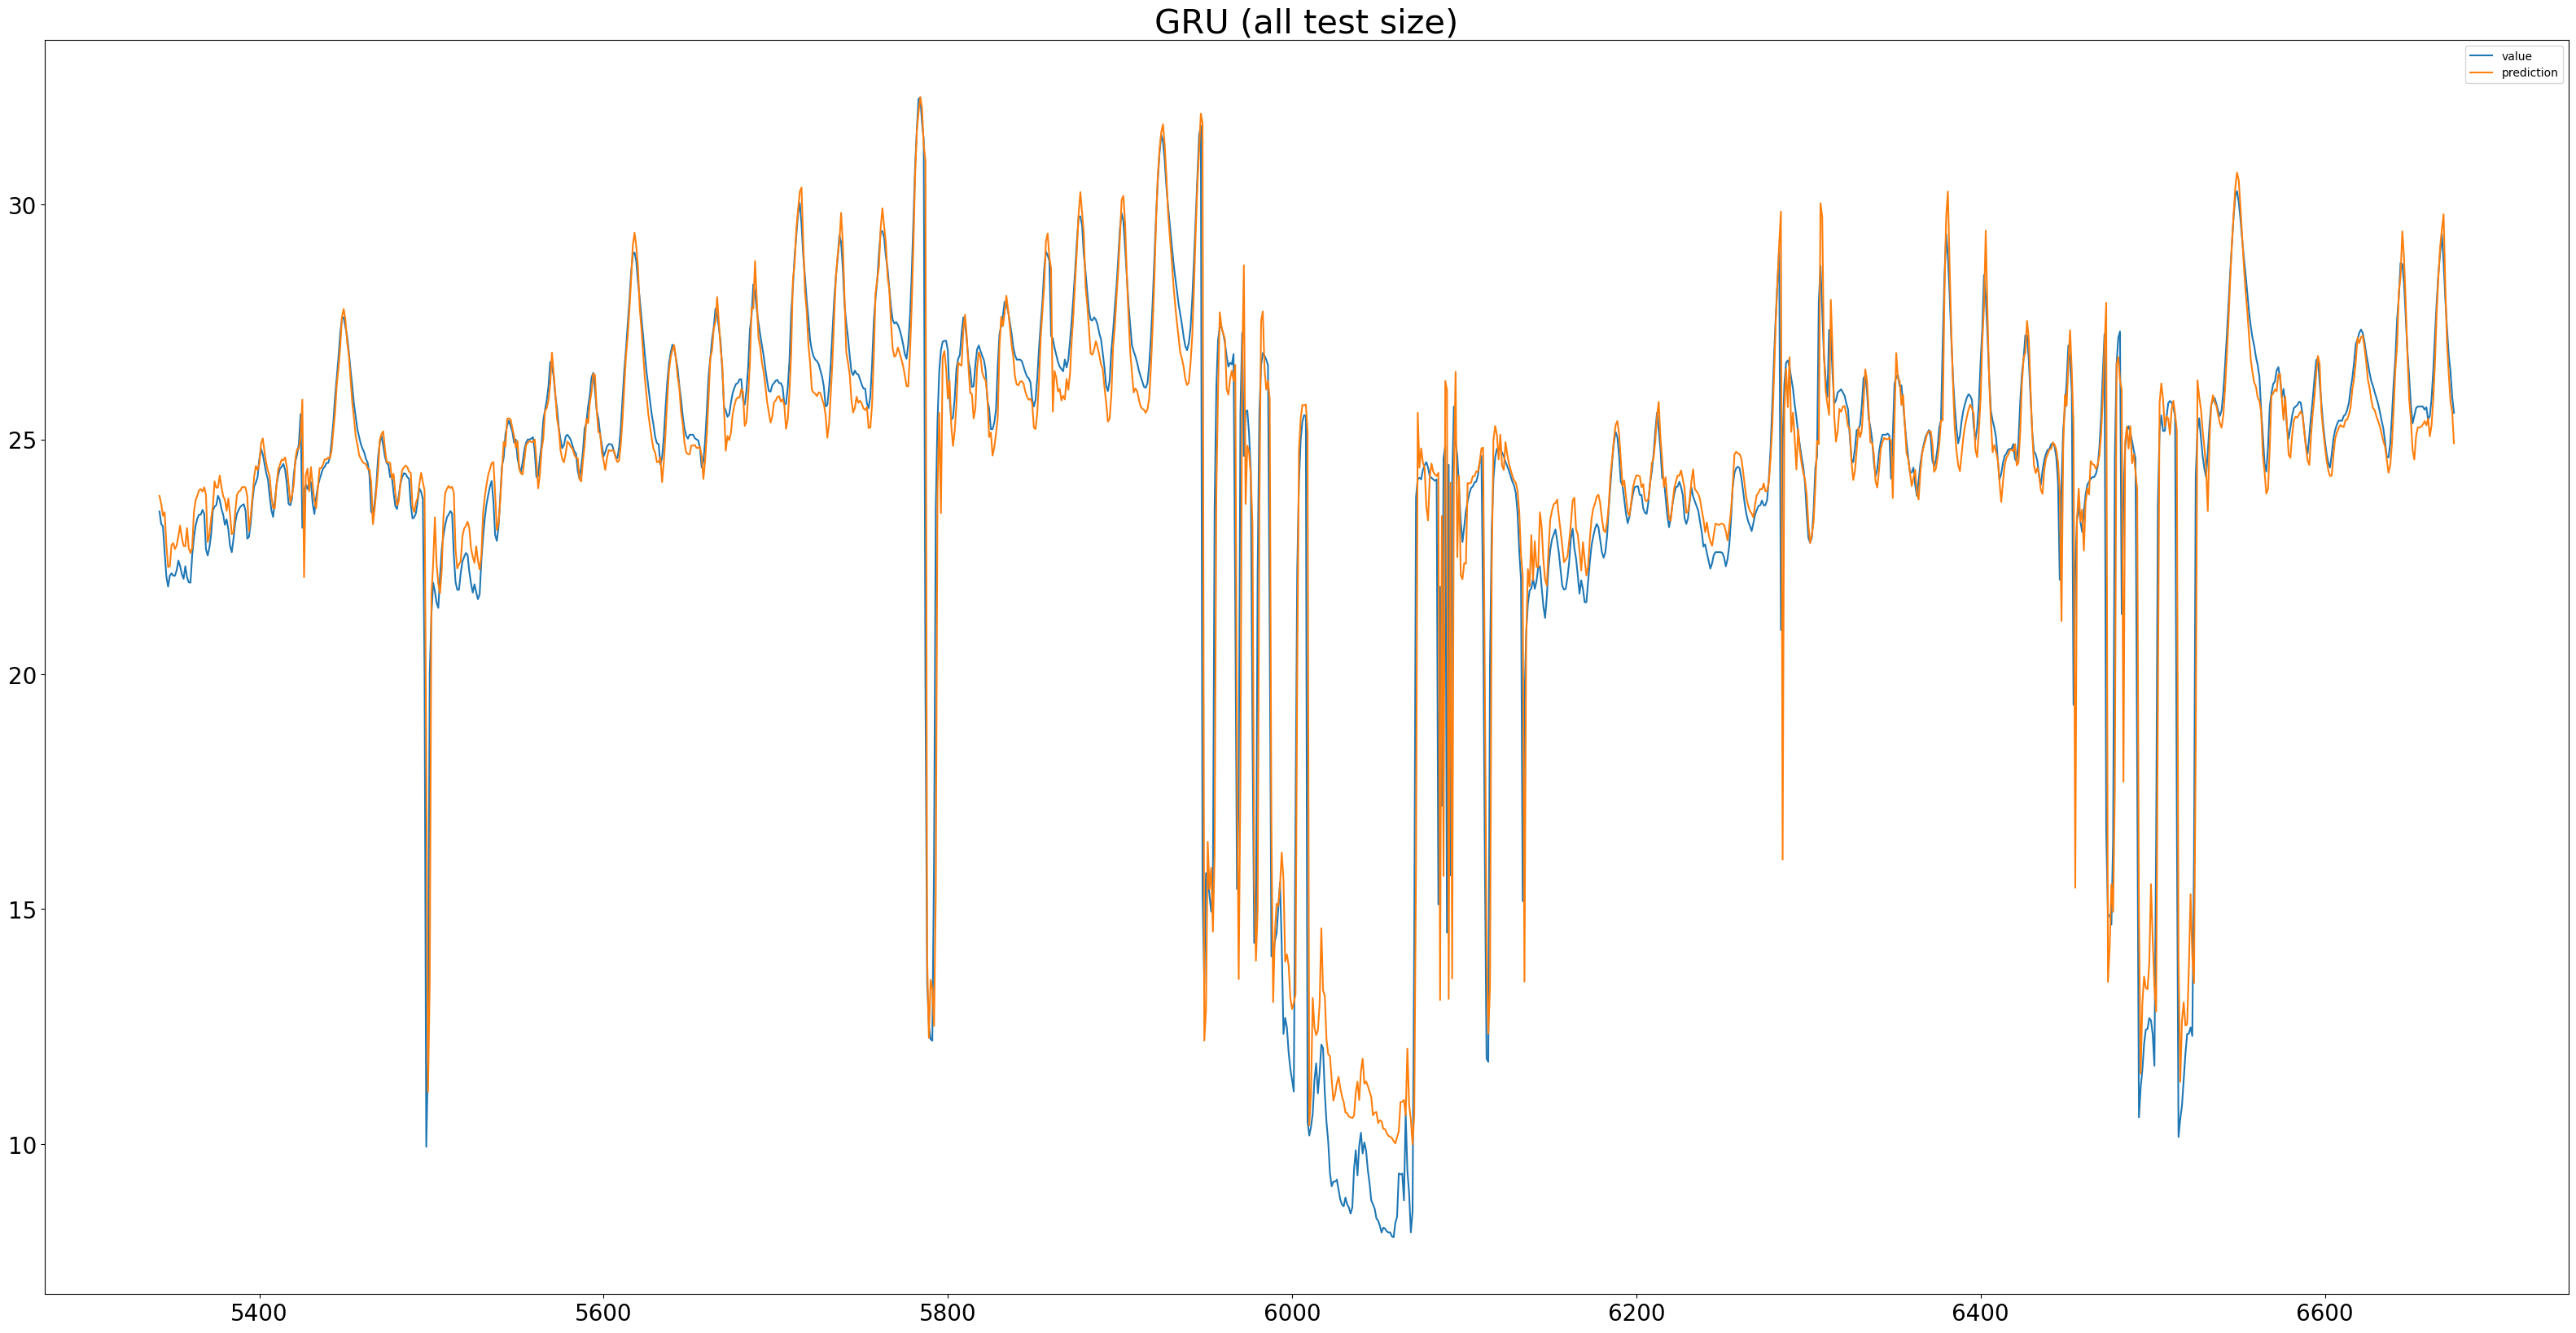

In [18]:
ax = df_result.plot(figsize = (40,20), fontsize=20)
ax.set_title('GRU (all test size)', fontsize = 30)

Text(0.5, 1.0, 'GRU (first 200 el)')

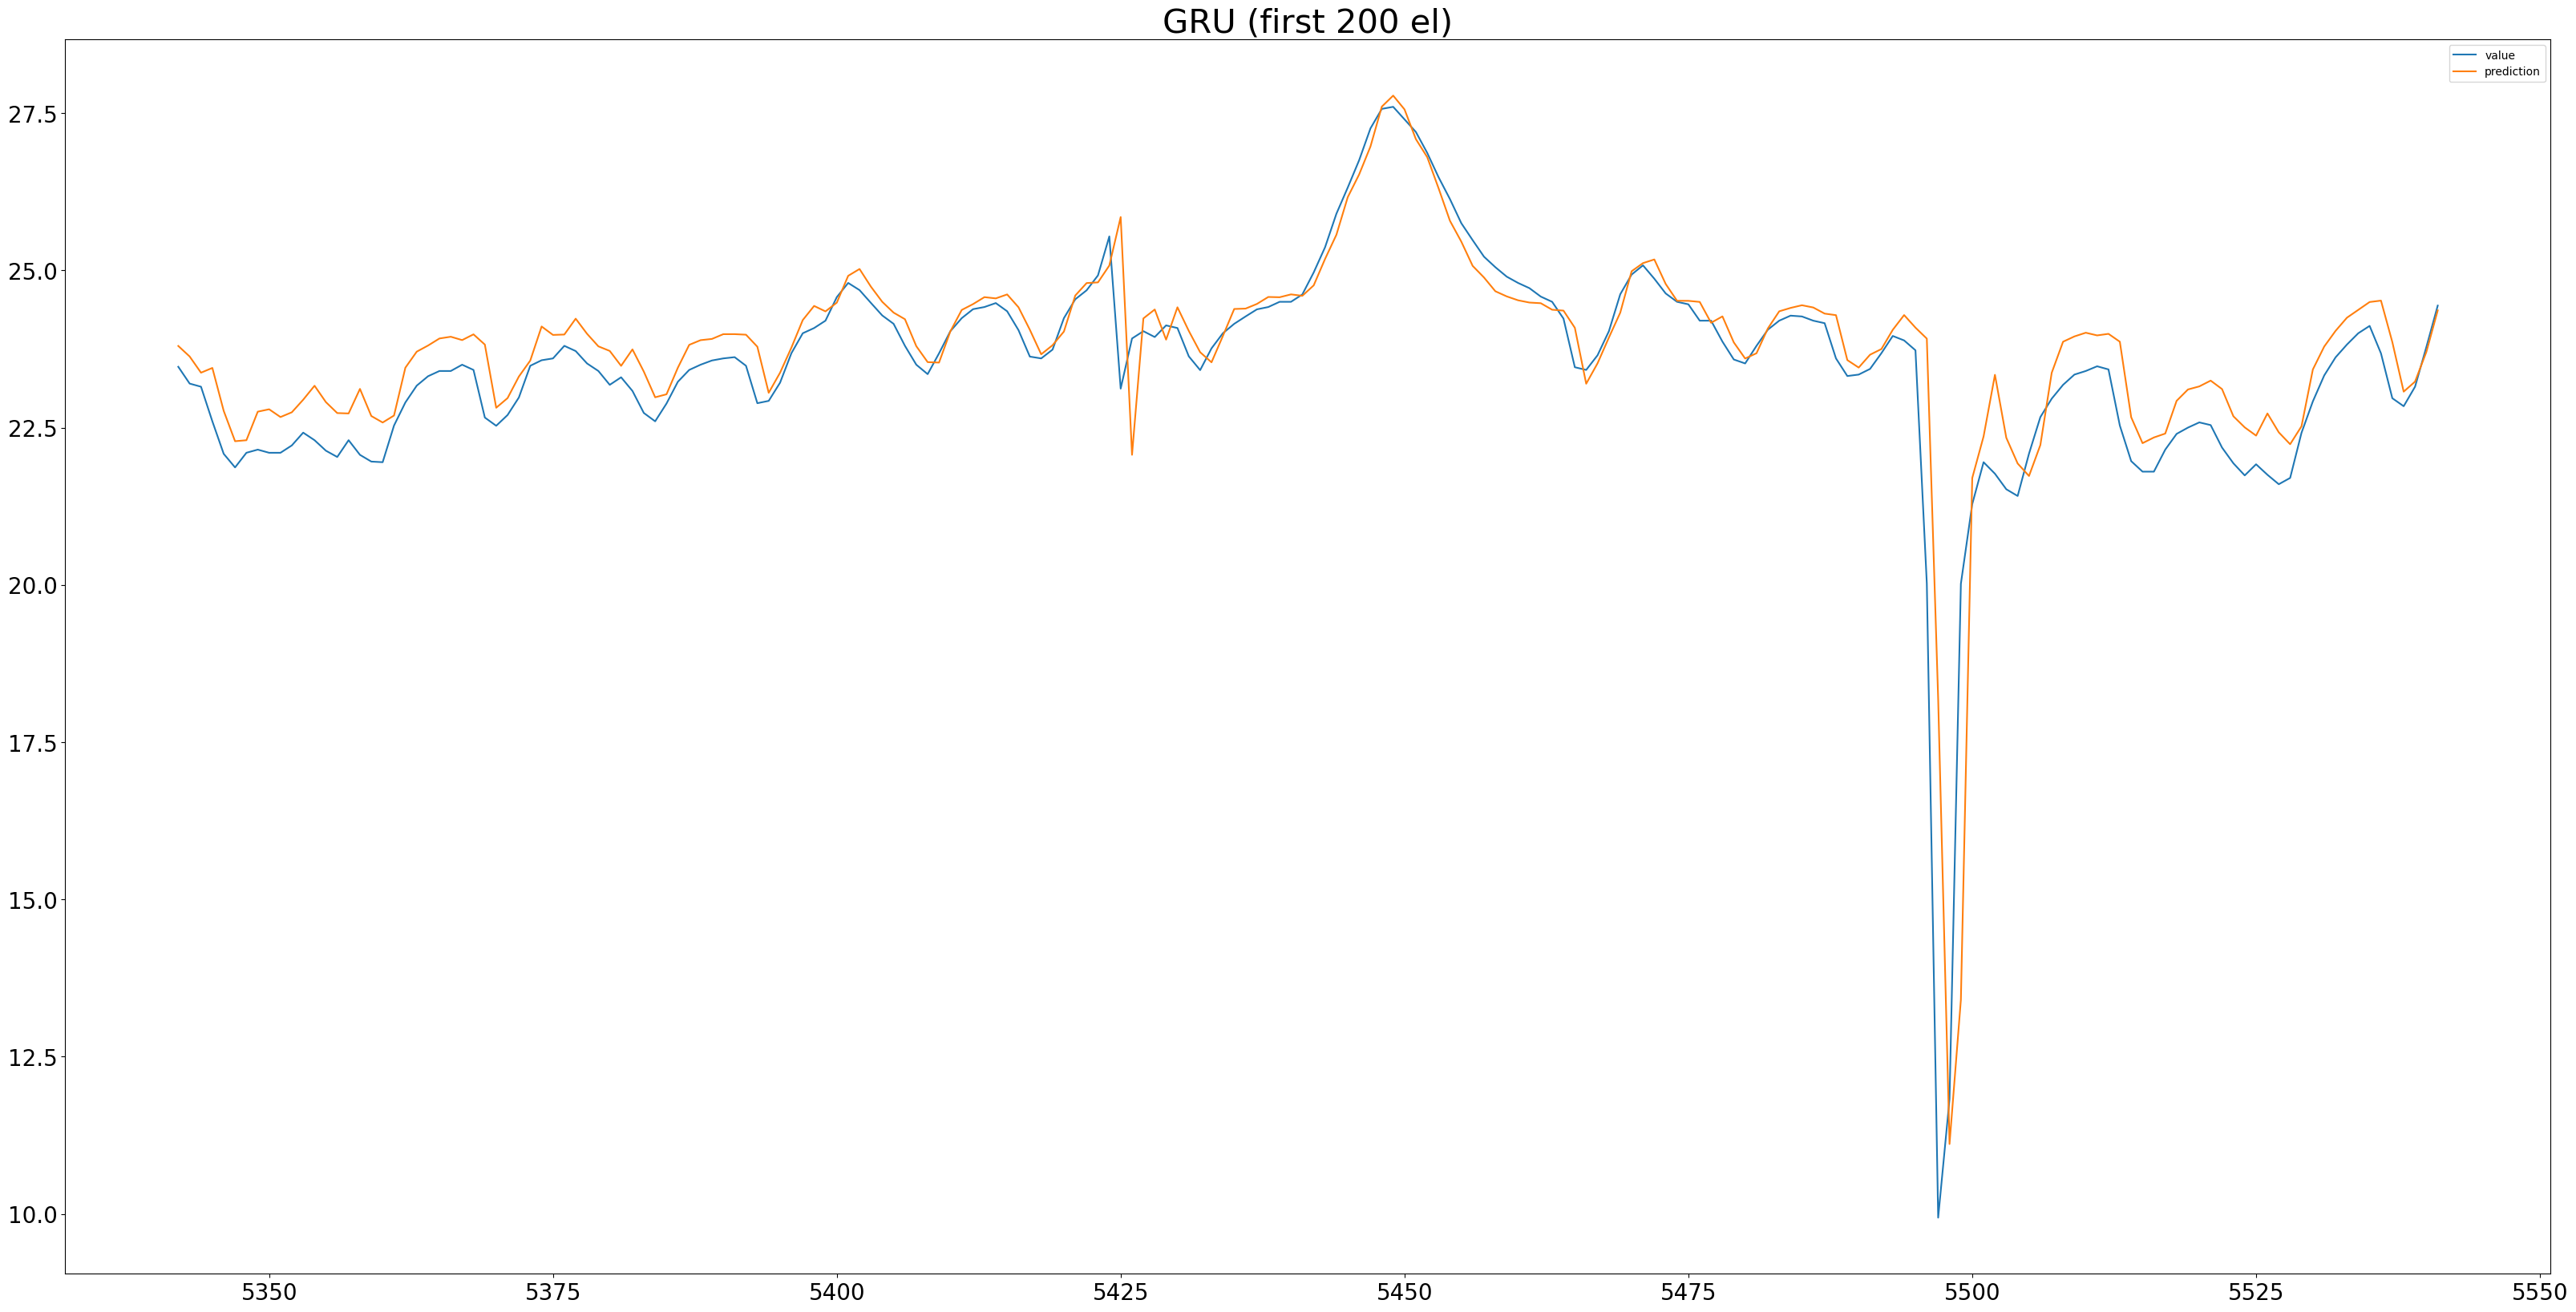

In [19]:
ax = df_result[:200].plot(figsize = (40,20), fontsize=20)
ax.set_title('GRU (first 200 el)', fontsize = 30)